# Instrumental Variables

## Going Around Omitted Variable Bias

One way to control for OVB is, well, add the omitted variable into our model. However, that is not always possible, mostly because we simply don't have data on the omitted variables. For instance, let's go back to our model for effect of education on wage:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}Ability_i + u_i
$

To figure out the causal effect of education \\(\kappa\\) on \\(log(hwage)\\), we need to control for ability factors \\(Ability_i\\). If we don't, we would likely have some bias. After all, ability is probably a confounder, causing both the treatment, education, and the outcome, earnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

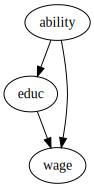

In [2]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

One way to avoid this is to control for constant levels of ability when measuring the effect of education on wage. We could do that by including ability in our linear regression model. However, we don't have good measurements of ability. The best we have are some very questionable proxies, like IQ.

But not everything is lost. Here is where Instrumental Variables enters the picture. The idea of IV is to find another variable that causes the treatment and it is only correlated with the outcome through the treatment. Another way of saying this is that this instrument \\(Z_i\\) is uncorrelated with \\(Y_0\\), but it is correlated with \\(T\\). This is sometimes referred to as the exclusion restriction.

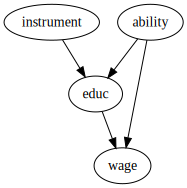

In [3]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

If we have such a variable, we can recover the causal effect \\(\kappa\\) with what we will see as the IV formula. To do so, let's think about the ideal equation we want to run. Using more general terms like \\(T\\) for the treatment and \\(W\\) for the confounders, here is want we want:

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

However, we don't have data on \\(W\\), so all we can run is

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

Since \\(W\\) is a confounder, \\(Cov(T, v) \neq 0\\). We have a short, not long equation. In our example, this would be saying that ability is correlated with education. If this is the case, running the short regression would yield a biased estimator for \\(\kappa\\) due to omitted variables. 

Now, behold the magic of IV! Since the instrument Z is only correlated with the outcome through T, this implies that \\(Cov(Z,v) = 0\\), otherwise there would be a second path from Z to Y through W. With this in mind, we can write

$
Cov(Z,Y) = Cov(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa Cov(Z,T) + Cov(Z, v) = \kappa Cov(Z,T)
$

Dividing each side by \\(V(Z_i)\\) and rearranging the terms, we get

$
\kappa = \dfrac{Cov(Y_i, Z_i)/V(Z_i)}{Cov(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

Notice that both the numerator and the denominator are regression coefficients (covariates divided by variances). The numerator is the result from the regression of Y on Z. In other words, it's the "impact" of Z on Y. Remember that this is not to say that Z causes Y, since we have a requirement that Z impacts Y only through T. Rather, it is only capturing how big is this effect of Z on Y through T. This numerator is so famous it has its own name: the reduced form.

The denominator is also a regression coefficient. This time, it is the regression of T on Z. This regression captures what is the impact of Z on T and it is also so famous that it is called the 1st Stage. 

Another cool way to look at this equation is in terms of partial derivatives. We can show that the impact of T on Y is equal to the impact of Z on Y, scaled by the impact of Z on T:

$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{\partial z}{\partial T} =  \dfrac{\partial y}{\partial T}
$

What this is showing to us is more subtle than most people appreciate. It is also cooler than most people appreciate. By writing IV like this, we are saying, "look, it's hard to find the impact of T on Y due to confounders. But I can easily find the impact of Z on Y, since there is nothing that causes Z and Y (exclusion restriction). However, I'm interested in the impact of T on Y, not Z on Y. So, I'ma estimate the easy effect of Z on Y and **scale it by the effect of Z on T**, to convert the effect to T units instead of Z units". 

We can also see this in a simplified case where the instrument is a dummy variable. In this case, the IV estimator gets further simplified by the ratio between 2 differences in means.

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

This ratio is sometimes referred to as the **Wald Estimator**. Again, we can tell the IV story where we want the effect of T on Y, which is hard to get. So we focus on the effect of Z on Y, which is easy. By definition, Z only affects Y through T, so we can now convert the impact of Z on Y to the impact of T on Y. We do so by scaling the effect of Z on Y by the effect of Z on T. 

## Quarter of Birth and the Effect of Education on Wage

So far, we've been treating these instruments as some magical variable \\(Z\\) which have the miraculous propriety of only affecting the outcome through the treatment. To be honest, good instruments are so hard to come by that we might as well consider them miracles. Let's just say it is not for the faint of heart. Rumor has it that the cool kids at Chicago School of Economics talk about how they come up with this or that instrument at the bar. 

![img](./data/img/iv/good-iv.png)

Still, we do have some interesting examples of instruments to make things a little more concrete. We will again try to estimate the effect of education on wage. To do so, we will use the person's quarter of birth as the instrument Z.

This idea takes advantage of US compulsory attendance law. Usually, they state that a kid must have turned 6 years by January 1 of the year they enter school. For this reason, kids that are born at the beginning of the year will enter school at an older age. Compulsory attendance law also requires students to be in school until they turn 16, at which point they are legally allowed to drop out. The result is that people born later in the year have, on average, more years of education than those born in the beginning of the year.

![img](./data/img/iv/qob.png)

If we accept that quarter of birth is independent of the ability factor, that is, it does not confound the impact of education on wage, we can use it as an instrument. In other words, we need to believe that quarter of birth has no impact on wage, other than through its impact on education. If you don't believe in astrology, this is a very compelling argument.

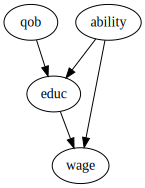

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

To perform this analysis, we can use data from three decennial census, the same data used by [Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991) in their article about IV. This dataset has information on log wages, our outcome variable, and years of schooling, our treatment variable. It also has data on quarter of birth, our instrument, and additional controls, such as year of birth and state of birth. 

In [5]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## The 1st Stage

Before we use quarter of birth as an instrument, we need to make sure it is a valid one. This implies arguing in favor of the two Instrumental Variables assumptions:

1. \\(Cov(Z, T) \neq 0\\). This is saying that we should have a strong 1st stage, or that the instrument indeed impacts the treatment variable.
2. \\(Y \perp Z | T \\). This is the exclusion restriction, stating that the instrument Z only affects the outcome Y through the treatment T. 

The first assumption is fortunately verifiable. We can see from data that \\(Cov(Z, T)\\) is not zero. In our example, if quarter of birth is indeed an instrument like we've said, we should expect individuals born in the last quarter of the year to have slightly more time of education than those born in the beginning of the year. Before running any statistical test to verify this, let's just plot our data and see it with our own eyes.

In [6]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

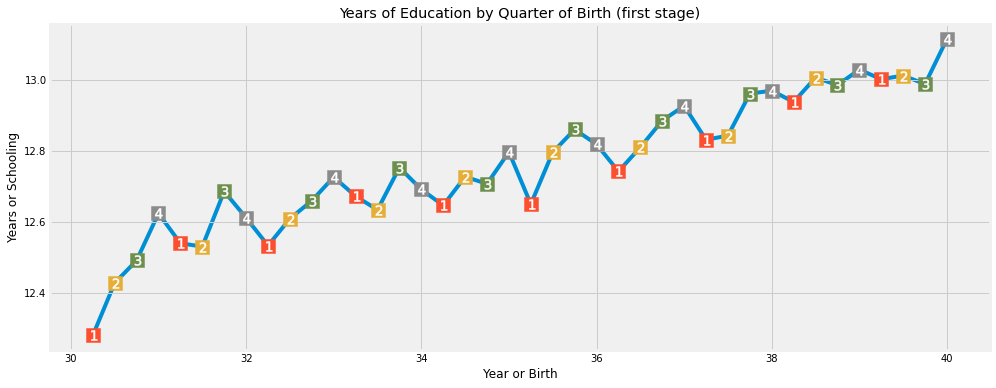

In [7]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year or Birth")
plt.ylabel("Years or Schooling");

Remarkably, there is a seasonal pattern on the years of schooling that follows the quarter of the year. Visually, we can see that those born in the first quarter of the year have almost always more education than those born in the last quarter (once we control for the year of birth, after all, those born in later years have more education, in general).

To be a bit more rigorous, we can run the 1st stage as a linear regression. We will first convert the quarter of birth to dummy variables:

In [8]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


For simplicity, let's only use the last quarter, q4, as the instrument for now. We will run a regression of years of schooling, the treatment, on quarter of birth, the instrument. This will show us if indeed quarter of birth positively affects time of education like we saw in the plot above. We also need to control for years of birth here and we will add state of birth as an additional control.

In [9]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785928
q4 p-value:,  5.4648294166376076e-15


It looks like those born in the last quarter of the year have, on average, 0.1 more years of education than those born in other quarters of the year. The P-value is close to zero. This closes the case as to if quarter of birth causes more or less years of schooling.

![img](./data/img/iv/incomplete-files.png)

## The Reduced Form

Unfortunately, we can't verify the second IV condition. We can only argue in favor of it. We can express our belief that quarter of birth does not influence potential earnings. In other words, the time people are born is not an indication of their personal ability or any other factor that can cause a difference in earnings, other than the effect on education. A good way of doing that is to say that qatar of birth is as good as randomly assigned when we are thinking about it's impact on earnings. (It isn't random. There is evidence that people tend to conceive around the end of the summer or around some sort of holiday. But I can't think of any good reason that this pattern also affects income in any way other than through education).

Having argued in favor of the exclusion restriction, we can proceed to run the reduced form. The reduced form aims at figuring out how the instrument influences the outcome. Since, by assumption, all this influence is due to the effect on treatment, this will shed some light into how the treatment affects the outcome. Once again, let's evaluate this visually before getting serious with regression. 

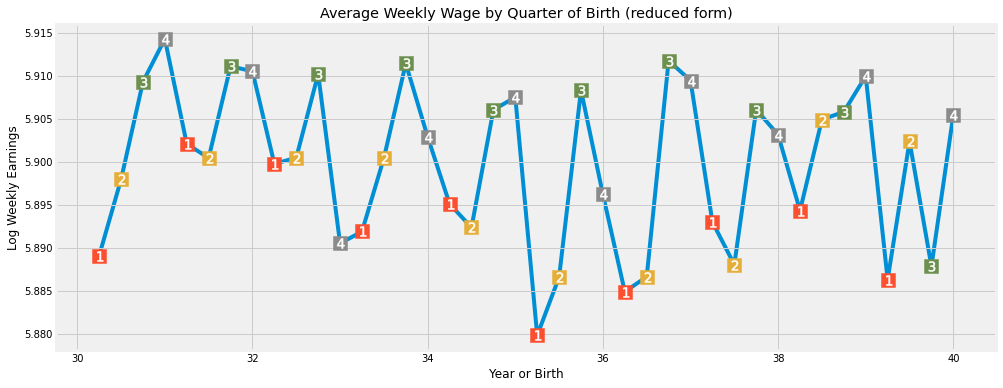

In [10]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year or Birth")
plt.ylabel("Log Weekly Earnings");

Once again, we can see a seasonal pattern on earnings by the quarter of birth. Those born later on the year have slightly higher income than those born in the beginning of the year. To test this hypothesis, we will again regress the instrumental q4 on log wage. We will also add the same additional controls as in the 1st stage:

In [11]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260138794
q4 p-value:,  0.0014949127183682181


Once again, we have a significant result. Those born in the last quarter of the year have, on average, 0.8% higher wages. This time, the P-value is not so close to zero as before, but it's still pretty significant, being just 0.0015. 

## Instrumental Variables by Hand

Having both our reduced form and our 1st stage, we can now scale the effect of the first stage by the reduced form. Since the reduced form was something like 0.1, this will multiply the effect of the reduced form by almost 10. This will give us our unbiased IV estimate of the average causal effect:

$
ATE_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

In [12]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492084653

This means that we should expect each additional year of school to increase wages by 8%.

Another way to get the IV estimates is by using 2 stages least squares, **2SLS**. With this procedure, we do the first stage like before and then run a second stage where we replace the treatment variable by the fitted values of the 1st stage

$
educ_i = \gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i
$

$
log(wage)_i = \beta_0 + \beta_1 educ_i + \beta_2 yob_i + \beta_3 sob_i + u_i
$

$
log(wage)_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 * q4_i + \gamma_2 yob_i + \gamma_3 sob_i + v_i ]  + \beta_2 yob_i + \beta_3 sob_i + u_i
$

One thing to notice is that **any additional control we add to the second stage should also be added to the first stage when doing IV**. 

In [13]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492117334

As you can see, the parameters are exactly the same. This second way of looking at IV can be useful for the intuition it gives. In IV, the first stage creates a new version of the treatment that is purged from omitted variable bias. We then use this purged version of the treatment, the fitted values of the 1st stage, in a linear regression.  

In practice, however, we don't do IV by hand. Not because it is troublesome, but because the standard errors we get from this second stage are a bit off. Instead, we should always let the machine do the job for us. In Python, we can use the library [linearmodels](https://bashtage.github.io/linearmodels/) to run 2SLS the right way.

The formula for 2SLS is a bit different. We should add the first stage between \[ \] inside the formula. In our case, we add `years_of_schooling ~ q4`. Additional controls don't need to be added to the first stage because the computer will do this automatically if we include them in the second stage. For this reason, we add `year_of_birth` and `state_of_birth` outside the formula of the 1st stage. 

In [14]:
from linearmodels.iv import IV2SLS

def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.08530286491100014
SE: 0.025540812813751597
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914672166424


Once again, we can see that the parameter is exactly the same as the ones we've got before. The extra benefit is that we have valid standard errors now. With this at hand, we can say that we expect 1 extra year of education to increase wages by 8.5%, on average. 

## Multiple Instruments

Another advantage of using the computers is to run 2SLS is that it is easy to add multiple instruments. In our example, we will use all quarter of birth dummies as instruments for years of schooling. 

In [15]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370488765162
SE: 0.019557149009699855
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


With all 3 dummies, the estimated return on education is now 0.1, which means that we should expect a 10% average increase on earnings for every additional year of education. Let's compare this with the traditional OLS estimate. To do that, we can use 2SLS again, but without the 1st stage now.

In [16]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817659044
SE: 0.0003883998439048642
95 CI: [0.06656446 0.06808699]
P-value: 0.0


The return on education is estimated to be lower with OLS than with 2SLS. This suggests that OVB might not be as strong as we first though. Also, notice the confidence intervals. 2SLS has a much wider CI than the OLS estimate. Let's explore this further

## Weakness of Instruments

![img](./data/img/iv/weak-iv.png)

When dealing with IV, we need to remember we are estimating the ATE indirectly. Our estimates depend on both the first stage and the second stage. If the impact of the treatment on the outcome is indeed strong, the second stage will also be strong. However, it doesn't matter how strong the second stage is if we have a weak first stage. A weak first stage means that the instrument has only a very small correlation with the treatment. Therefore, we can't learn much about the treatment from the instrument.

The formulas for the IV standard errors are a bit complex and not so intuitive, so we will try something else to grasp this problem. We will simulate data where we have a treatment T with effect 2.0 on the outcome Y, an unobserved confounder U and an additional control X. We will also simulate multiple instruments with different strengths on the 1st stage.

$
X \sim N(0, 2^2)\\
U \sim N(0, 2^2)\\
T \sim N(1+0.5U, 5^2)\\
Y \sim N(2+ X - 0.5U + 2T, 5^2)\\
Z \sim N(T, \sigma^2) \text{ for }\sigma^2 \text{ in 0.1 to 100}
$

In [17]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


Just to double check, we can see that the correlation between Z and T is indeed decreasing.

In [18]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

Now, we will run one IV model per instrument we have and collect both the ATE estimate and the standard error.

In [19]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

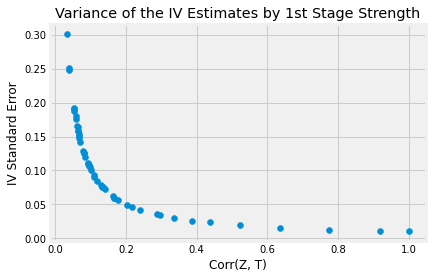

In [20]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

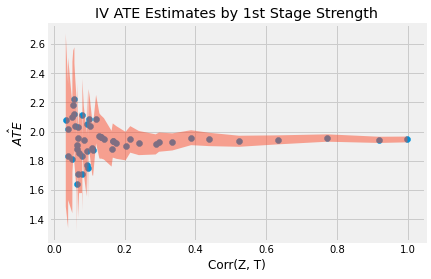

In [21]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

As we can see in the plots above, estimates vary wildly when the correlation between T and Z is weak. This is because the SE also increases a lot when the correlation is low.

Another thing to notice is that **2SLS is biased**! Even with high correlation, the parameter estimate still does not reach the true ATE of 2.0. Actually, 2.0 is not even in the 95% CI! 2SLS is only consistent, which means that it approaches the true parameter value if the sample size is big enough. However, we can't know how big is big enough. We can only stick by some rules of thumb to understand how this bias behaves:

1. 2SLS is biased towards OLS. This means that if OLS has a negative/positive bias, 2SLS will also have it. The advantage of 2SLS is that it is at least consistent, where OLS is not, in the case of omitted variables. In the example above, our unobserved U impacts negatively the outcome but its positively correlated with the treatment, which will result in a negative bias. That is why we are seeing the ATE estimate below the true value (negative bias).

2. The bias will increase with the number of instruments we add. If we add too many instruments, 2SLS becomes more and more like OLS.

Besides knowing how this bias behaves, a final piece of advice is to avoid some **common mistakes when doing IV**:

1. Doing IV by hand. As we've seen, IV by hand will result in wrong standard errors, even if the parameter estimates are right. The SE won't be completely off. Still, why do it if you can use software and get the right SE?

2. Using anything other than OLS on the 1st stage. Lots of Data Science encounter IV and think they can do better. For example, they see a dummy treatment and think about replacing the 1st stage by a logistic regression, after all, they are predicting a dummy variable, right?. The problem is that this is plain wrong. The consistency of IV relies on a property that only OLS can give, which is the orthogonality of the residuals, so anything different than OLS on the 1st stage will yield something biased. (OBS: there are some modern techniques that use Machine Learning for IV, but their results have been, at best, questionable).

## Key Ideas

We've taken some time here to understand how we can work around omitted variable bias if we have an instrument variable. An instrument is a variable that is correlated with the treatment (has a first stage), but only affects the outcome through the treatment (exclusion restriction). We saw an example of an instrument with quarter of birth to estimate the effect of education on income.

We then delve into the mechanics of estimating the causal effect with IV, namely, using 2SLS. We've also learned that IV is no silver bullet. It can be quite troublesome when we have a weak first stage. Also, although consistent, 2SLS is still a biased method to estimate the causal effect. 

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)


![img](./data/img/poetry.png)